# Pathway Enrichment from LR loadings

This tutorial is focused on running two approaches to get functional footprints for each factor based on the loadings obtained for ligand-receptor pairs after running Tensor-cell2cell: 
 - GSEA: implemented by using the library `gseapy`, which has its own documentation (https://gseapy.readthedocs.io/en/latest/), as an external function in `cell2cell`.
 - PROGENy: implemented by using the library `decoupler-py`, which has its own documentation (https://decoupler-py.readthedocs.io/en/latest), as an external function in `liana`.

In [1]:
import cell2cell as c2c
import liana as li

import pandas as pd

import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [3]:
output_folder = '../Figures/'
c2c.io.directories.create_directory(output_folder)

../Figures/ already exists.


## Load Data

**Open the loadings obtained from the tensor factorization**

In [4]:
factors = c2c.io.load_tensor_factors(output_folder + '/Loadings.xlsx')

**Load list of LR pairs used as reference to [run LIANA](./02-Infer-Communication-Scores.ipynb)**

In [5]:
lr_pairs = li.resource.select_resource('consensus')

**Generate a list with the LR pair names**

GSEA and PROGENy were originally designed to work with list of genes. Here we are using ligand-receptor pairs, so instead of using Gene Sets we need to build our LR-gene sets. This list is a first step to build the LR-gene sets.

In [6]:
lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()] 

## GSEA

In this case, we will run the PreRank method of GSEA since our LR pairs are pre-ranked based on their loadings in each factor obtained by Tensor-cell2cell.

### Generate LR-gene set for running GSEA

`cell2cell` includes some resources associated with the Gene sets employed in GSEA. It includes annotations of GO Terms (BP), KEGG, and Reactome, for human and mouse.

**First, specify which organism and annotation DB to use**

In [7]:
organism = 'human' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'GOBP' # GO Terms (Biological Processes)

**Generate the LR-gene set that will be used for running GSEA**

In [8]:
lr_set = c2c.external.generate_lr_geneset(lr_list,
                                          complex_sep='_', # Separation symbol of the genes in the protein complex
                                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                                          organism=organism,
                                          pathwaydb=pathwaydb,
                                          readable_name=True
                                         )

### Run GSEA

This external function implemented in `cell2cell` builds upon the function `gseapy.prerank()`.

In [9]:
pvals, scores, gsea_df = c2c.external.run_gsea(loadings=factors['Ligand-Receptor Pairs'], 
                                               lr_set=lr_set,
                                               output_folder=output_folder,
                                               weight=1,
                                               min_size=15,
                                               permutations=999,
                                               processes=6,
                                               random_state=6,
                                               significance_threshold=0.05,
                                              )

../Figures/ already exists.


  0%|          | 0/8 [00:00<?, ?it/s]

2023-02-01 15:59:13,397 [WARNING] Duplicated values found in preranked stats: 0.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-02-01 15:59:28,644 [WARNING] Duplicated values found in preranked stats: 2.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-02-01 15:59:43,014 [WARNING] Duplicated values found in preranked stats: 1.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-02-01 15:59:56,123 [WARNING] Duplicated values found in preranked stats: 1.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-02-01 16:00:08,820 [WARNING] Duplicated values found in preranked stats: 0.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-02-01 16:00:23,608 [WARNING] Duplicated values found in preranked stats: 1.83% of genes
The order of those genes will be

### Visualization

We can use the `pvals`and `scores`outputs to visualize the results as a Dot Plot:

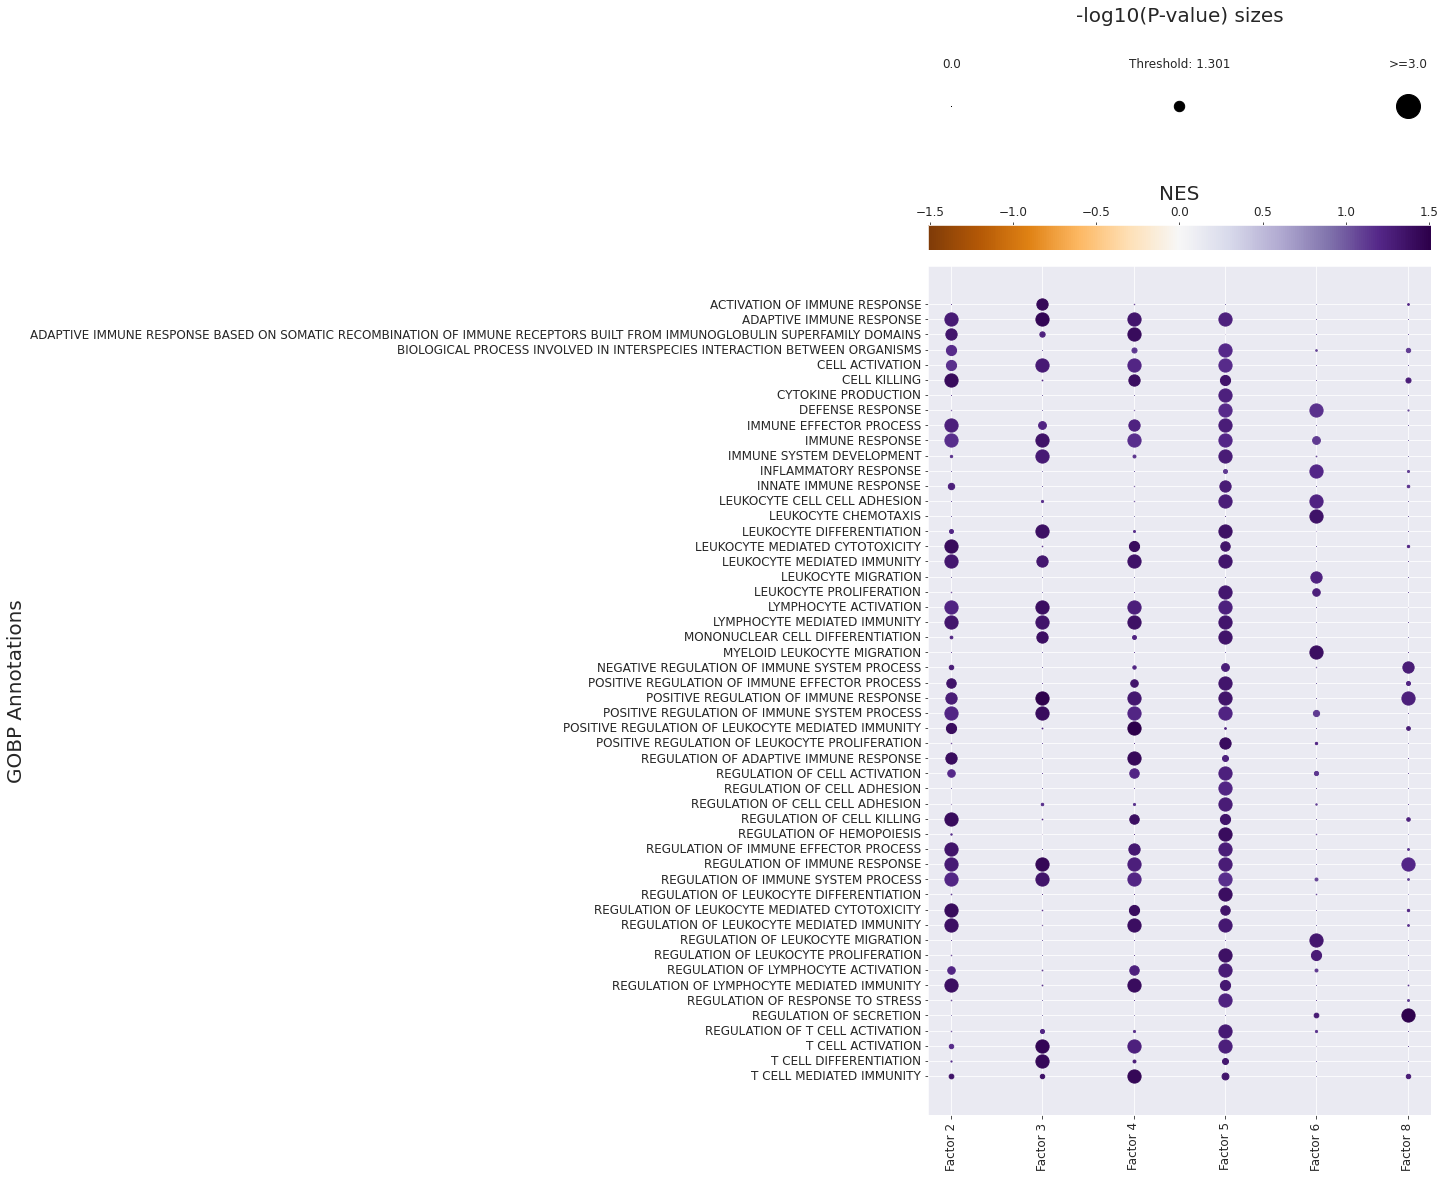

In [10]:
with sns.axes_style("darkgrid"):
    dotplot = c2c.plotting.pval_plot.generate_dot_plot(pval_df=pvals,
                                                       score_df=scores,
                                                       significance=0.05,
                                                       xlabel='',
                                                       ylabel='{} Annotations'.format(pathwaydb),
                                                       cbar_title='NES',
                                                       cmap='PuOr',
                                                       figsize=(9, 20),
                                                       label_size=20,
                                                       title_size=20,
                                                       tick_size=12,
                                                       filename=output_folder + '/GSEA-Dotplot.pdf'
                                                      )

**Similarly, we can use gsea_df to easily see the Enriched Pathways**

In [11]:
gsea_df.loc[(gsea_df['Adj. P-value'] < 0.05) & (gsea_df['NES'] > 0.)]

,Factor,Term,NES,P-value,Adj. P-value
0,Factor 2,CELL KILLING,1.424661,0.001000,0.022390
1,Factor 2,REGULATION OF LEUKOCYTE MEDIATED CYTOTOXICITY,1.420311,0.001001,0.022390
2,Factor 2,LEUKOCYTE MEDIATED CYTOTOXICITY,1.420311,0.001001,0.022390
3,Factor 2,REGULATION OF CELL KILLING,1.420220,0.001000,0.022390
4,Factor 2,REGULATION OF ADAPTIVE IMMUNE RESPONSE,1.408699,0.002002,0.038959
...,...,...,...,...,...
1148,Factor 6,DEFENSE RESPONSE,1.163189,0.001000,0.022390
1668,Factor 8,REGULATION OF SECRETION,1.485232,0.001001,0.022390
1669,Factor 8,NEGATIVE REGULATION OF IMMUNE SYSTEM PROCESS,1.292872,0.002002,0.038959
1674,Factor 8,POSITIVE REGULATION OF IMMUNE RESPONSE,1.267184,0.001001,0.022390


**And Depleted Pathways**

In [12]:
gsea_df.loc[(gsea_df['Adj. P-value'] < 0.05) & (gsea_df['NES'] < 0.)]

,Factor,Term,NES,P-value,Adj. P-value


## PROGENy